In [2]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
from torchvision.datasets import CelebA
import matplotlib.pyplot as plt

from utils.image import *
from utils.io import *
from modules.conv2d_resblock import Conv2DResBlock

/opt/homebrew/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [3]:
class IIF(nn.Module):
    def __init__(self, dims=3, channels=128, blocks=8):
        super().__init__()

        self.dims = dims

        self.encoder = nn.Sequential(
            nn.Conv2d(self.dims, channels, 9, 1, 4),
            Conv2DResBlock(channels, channels, 5, 1, 2),
            Conv2DResBlock(channels, channels, 5, 1, 2),
            Conv2DResBlock(channels, channels, 5, 1, 2),
            Conv2DResBlock(channels, channels, 5, 1, 2),
            nn.Conv2d(channels, self.dims, 1, 1, 0),
        )

        self.decoder = nn.Sequential(
            nn.Linear(2 + 32 * 32 * 3, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 3),
        )

    def _sample_latent(self, Z, x):
        z = Z
        return z

    def forward(self, image, mask, x):
        # image: (batch_size, 3, 32, 32)
        # mask:  (batch_size, 3, 32, 32)
        # x:     (batch_size, n, 2)

        Z = self.encoder(image)
        Z *= mask
        z = self._sample_latent(Z, x)

        # Z: (batch_size, 3, 32, 32)
        # x: (batch_size, n, 2)

        z = z.flatten(1)
        # z: (batch_size, 3 * 32 * 32)

        # decoder_input = torch.hstack((x, z.unsqueeze(0).repeat(1, x.shape[-2], 1)))
        decoder_input = torch.cat((x, z.unsqueeze(1).repeat(1, x.shape[-2], 1)), -1)
        s = self.decoder(decoder_input)

        return s


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = CelebA(
    "data",
    "train",
    download=False,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Resize((32, 32))]),
)
dataloader = DataLoader(dataset, 8, shuffle=True, num_workers=4)


In [26]:
model = IIF().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)


def to_coords(image: torch.Tensor, mask: torch.Tensor):
    # image: (batch_size, 3, 32, 32)
    # mask: (batch_size, 3, 32, 32)
    coords = mask[0, 0].nonzero(as_tuple=True)
    image_data = image[..., :, coords[0], coords[1]].transpose(-1, -2)

    coords = mask[0, 0].nonzero().unsqueeze(0).repeat(image_data.shape[0], 1, 1)

    return (image_data, coords)


def from_coords(shape, x, s):
    # x: (batch_size, n, 2)
    # s: (batch_size, n, 3)
    image = torch.zeros(shape, device=x.device)
    # image: (batch_size, n, 32, 32)

    for i in range(shape[0]):
        image[i, :, x.T[0], x.T[1]] = s.T

    return image


In [6]:
model.train()

for i, (images, _) in enumerate(dataloader):
    images = images.to(device)
    masked, mask = mask_random(images, 0.5)

    s, x = to_coords(images, mask.logical_not())
    x = x / 16.0 - 1.0  # (-1, 0)

    # s: (batch_size, n, 3)
    # x: (batch_size, n, 2)

    optimizer.zero_grad()
    s_pred = model(masked, mask, x)

    loss = ((s - s_pred) ** 2).mean()
    loss.backward()
    optimizer.step()

    if i == 10:
        break

    if i % 10000 == 0:
        print(f"iteration {i} - loss {loss.item()}")


iteration 0 - loss 0.2815866470336914


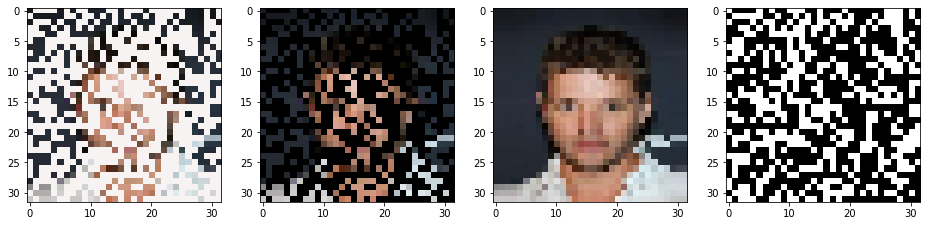

In [35]:
model.eval()

images, _ = next(iter(dataloader))
images = images.to(device)

masked, mask = mask_random(images, 0.4)
s, x = to_coords(masked, mask.logical_not())
s_pred = model(masked, mask, x)

plt.figure(figsize=(16, 4))

plt.subplot(141)
plt.imshow(to_pil_image((from_coords((8, 3, 32, 32), x, s_pred) + images * mask)[0]))
plt.subplot(142)
plt.imshow(to_pil_image(masked[0]))

plt.subplot(143)
plt.imshow(to_pil_image(images[0]))

plt.subplot(144)
plt.imshow(to_pil_image(mask[0]))

plt.show()
